# Aprendizado de Máquina em Séries Temporais

### Modelo SARIMA para predição de temperaturas de SST - Sea Surface Temperature Forecasting

### Introdução

Modelos SARIMA são modelos univariados para séries temporais. O acrônimo SARIMA significa modelos AutoRegressivos Integrados de Médias Móveis com Sazonalidade. [Referência](https://analisemacro.com.br/economia/comentario-de-conjuntura/modelos-sarima/)

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [2]:
from netuno import SSTHelper

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Variáis globais para esse arquivo

In [3]:
HORIZONTE = 12 # número de previsões a serem feitas (à frente da data)
AUTO_TUNE = True # se True, não faz a otimização de hiperparâmetros com o auto_arima (demorado)

### Carrengando o dataset

In [6]:
fp = 'dados/sst.mnmean.nc'
ds = SSTHelper.load_dataset(fp)

In [7]:
df = SSTHelper.load_dataframe(ds)

In [8]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


In [9]:
df['lon'] = df['lon'].copy().apply(SSTHelper.f)

### Pegando as temperaturas de um ponto no globo


* P1: Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* P2: Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* P3: Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* P4: Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* P5: Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [10]:
p1_enso   = SSTHelper.get_sst_series_default(df, SSTHelper.f(20)  , -132)
p2_chile  = SSTHelper.get_sst_series_default(df, SSTHelper.f(-22) ,  -72)
p3_medit  = SSTHelper.get_sst_series_default(df, SSTHelper.f(36)  ,   18)
p4_atlan  = SSTHelper.get_sst_series_default(df, SSTHelper.f(0)   ,  -22)
p5_indic  = SSTHelper.get_sst_series_default(df, SSTHelper.f(-56) ,   80)

#### Verificando se os pontos do dataset foram carregados

In [11]:
p1_enso.head()
# p2_chile.head()
# p3_medit.head()
# p4_atlan.head()
# p5_indic.head()

,lat,lon,sst
time,,,
1854-01-01,20.0,-132.0,22.197483
1854-02-01,20.0,-132.0,21.905436
1854-03-01,20.0,-132.0,22.155600
1854-04-01,20.0,-132.0,22.680405
1854-05-01,20.0,-132.0,22.942524


### Plotando a temperatura de um ponto do globo através do tempo

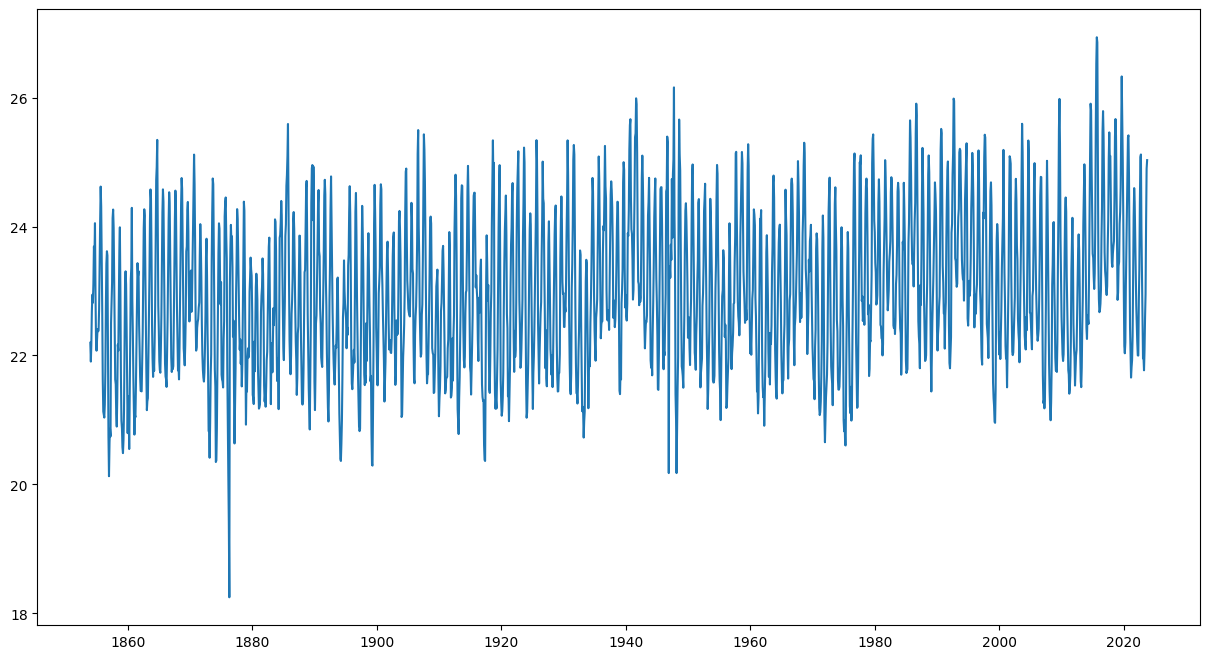

In [15]:
# para toda a séries p1_enso
index = p1_enso.index.tolist()
plt.figure(figsize=(15,8))
plt.plot(index, p1_enso['sst'])
plt.show()

#### Plotando para as primeiras leituras

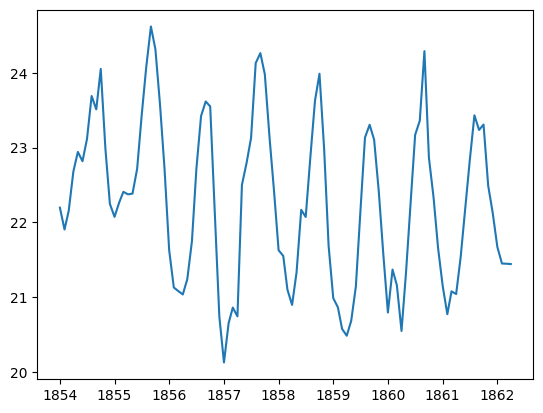

In [16]:
#plotando a temperatura do ponto atravéz do tempo para as primeiras 100 leituras
index = p1_enso.index.tolist()
plt.plot(index[:100],p1_enso['sst'][:100])
plt.show()

### Dividindo em treino e teste para os pontos do globo escolhidos

In [17]:
DATE_TO_SPLIT = '2021-12-01' #data limite para dividir em treino[:DATA_LIMITE] e teste[DATA_LIMITE:]
END_WINDOW = HORIZONTE #janela para usar como teste no conjunto de teste 

# enso
treino_enso, teste_enso = SSTHelper.split_train_test(p1_enso, DATE_TO_SPLIT)
teste_enso = teste_enso[:END_WINDOW]
treino_enso.drop(['lat', 'lon'], axis=1, inplace=True)
teste_enso.drop(['lat', 'lon'], axis=1, inplace=True)

# chile
treino_chile, teste_chile = SSTHelper.split_train_test(p2_chile, DATE_TO_SPLIT)
teste_enso = teste_enso[:END_WINDOW]
treino_chile.drop(['lat', 'lon'], axis=1, inplace=True)
teste_chile.drop(['lat', 'lon'], axis=1, inplace=True)

# mediterrâneo
treino_medit, teste_medit = SSTHelper.split_train_test(p3_medit, DATE_TO_SPLIT)
teste_medit = teste_medit[:END_WINDOW]
treino_medit.drop(['lat', 'lon'], axis=1, inplace=True)
teste_medit.drop(['lat', 'lon'], axis=1, inplace=True)

# atlântico
treino_atlan, teste_atlan = SSTHelper.split_train_test(p4_atlan, DATE_TO_SPLIT)
teste_atlan = teste_atlan[:END_WINDOW]
treino_atlan.drop(['lat', 'lon'], axis=1, inplace=True)
teste_atlan.drop(['lat', 'lon'], axis=1, inplace=True)

# ìndico
treino_indic, teste_indic = SSTHelper.split_train_test(p5_indic, DATE_TO_SPLIT)
teste_indic = teste_indic[:END_WINDOW]
treino_indic.drop(['lat', 'lon'], axis=1, inplace=True)
teste_indic.drop(['lat', 'lon'], axis=1, inplace=True)

In [18]:
print('Shape de treino (ENSO): ', treino_enso.shape)
print('Shape de teste (ENSO): ' , teste_enso.shape)

Shape de treino (ENSO):  (2016, 1)
Shape de teste (ENSO):  (12, 1)


#### Dados de treino (ENSO)

In [19]:
treino_enso.tail()

,sst
time,
2021-08-01,24.145559
2021-09-01,24.596079
2021-10-01,24.381094
2021-11-01,23.861654
2021-12-01,23.306463


#### Dados de teste (ENSO) - limitado ao horizonte

In [20]:
teste_enso.tail(HORIZONTE)

,sst
time,
2022-01-01,22.776232
2022-02-01,22.454197
2022-03-01,22.204994
2022-04-01,22.001392
2022-05-01,21.998831
2022-06-01,22.841663
2022-07-01,23.332996
2022-08-01,24.358280
2022-09-01,25.077301


### Otimizando os hiper-parâmetros do SARIMA para o conjunto de treino

Os hiperparâmetros `order`$= (p, q, d)$ e `sazonal_order`$=(P, Q, D, m)$ usados para treinar o modelos serão obtido pelo otimizador **auto_arima** do seguinte pacote, https://alkaline-ml.com/pmdarima/

O hiperparãmetro `order` é um parâmetro que tem a ver com a parte de trending do modelo:

 - $p$: Trend autoregression order

 - $q$: Moving average order

 - $d$: Trend moving average order

e os parâmetros de sazonalidade referente ao `sazonal_order`:

 - $P$: Seasonal autoregressive order

 - $D$: Seasonal difference order

 - $Q$: Seasonal moving average order

 - $m$: o número de passos no tempo para um único período de sazonalidade

#### Auto arima otimizator:


In [174]:
# https://alkaline-ml.com/pmdarima/
import pmdarima as pm

# Procura pelos melhores parâmetros (order e seasonal_order)
if (AUTO_TUNE):
    auto_model = pm.auto_arima(treino_enso, start_p=1, start_q=0,
                               max_p=5, max_q=0, m=24,
                               start_P=0, max_P=2,Q=0, 
                               seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    print(auto_model.aic())
    print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=10.84 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=3270.504, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=2709.528, Time=1.20 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=inf, Time=6.19 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=3257.862, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=2498.145, Time=1.95 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=44.44 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=17.11 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=2514.605, Time=1.98 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=2463.490, Time=3.31 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=2670.137, Time=1.35 sec
 ARIMA(2,1,0)(2,1,1)[24]             : AIC=inf, Time=56.36 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=22.14 sec
 ARIMA(3,1,0)(2,1,0)[24]             : AIC=2433.030, Time=3.64 sec
 ARIMA(3,1,0)(1,1,0)[24]             : AIC=2

### Treinando o modelo SARIMAX com o conjunto de treino do ponto no ENSO (El Niño-Southern Oscillation)

Ao obter os parâmetros `order` e `seadonal_order` do otimizador **auto_arima** do bloco anterior, treinamos o modelo com o conjunto de treino para um horizonte à frente.

In [21]:
# parâmetro obtidos do otimizador auto_arima
order_enso         = (5, 1, 0) #(p, q, d)
sazonal_order_enso = (2, 1, 0, 24) #(P, Q, D, m)

model_enso = SARIMAX(endog=treino_enso, order=order_enso, seasonal_order=sazonal_order_enso)
model_fit_enso = model_enso.fit()
y_predito_enso = model_fit_enso.forecast(steps = HORIZONTE)
#print(model_fit.summary())

### Resultado para o treino de um apenas um modelo

O conjunto de treino vai até 01/12/2021. Então, o modelo realiza a previsão para o horizonte definido

#### Valores preditos para o horizonte definido (12 meses)

In [22]:
y_predito_enso.to_frame()

,predicted_mean
2022-01-01,22.346516
2022-02-01,21.773057
2022-03-01,21.645948
2022-04-01,21.783298
2022-05-01,22.170572
2022-06-01,22.708853
2022-07-01,23.250181
2022-08-01,24.206224
2022-09-01,24.585447
2022-10-01,24.384045


In [23]:
y_atual_enso = SSTHelper.get_subseries_by_date(teste_enso, DATE_TO_SPLIT, END_WINDOW)
y_atual_enso.tail(END_WINDOW)

,sst
time,
2022-01-01,22.776232
2022-02-01,22.454197
2022-03-01,22.204994
2022-04-01,22.001392
2022-05-01,21.998831
2022-06-01,22.841663
2022-07-01,23.332996
2022-08-01,24.358280
2022-09-01,25.077301


#### Erro quadrático médio obtido (RMSE)

In [24]:
SSTHelper.rmse(y_atual_enso, y_predito_enso)

0.45786544644015686

#### Mean Absolute Percentage Error (MAPE)

In [25]:
SSTHelper.mape(y_atual_enso, y_predito_enso)

0.01683551691542555

### SARIMA: Usando a técnica walk-forward validation

Será realizada uma [**walk-forward validation**](https://www.tutorialspoint.com/time_series/time_series_walk_forward_validation.htm) que é muito boa para usar em projetos próprios de forecasting de séries temporais.

Primeiro, o modelo é treinado com o dataset de treino. Então, é realizada a predição no próximo passo em que a predição é avaliada em contraste com o valor conhecido. O dataset de treino é expandido para incluir o novo valor conhecido e o processo é repetido. 

Na prática o modelo SARIMAX é re-treinado em cada iteração do loop assim que novos pontos do histórico ficam disponíveis.

Re-treinar o modelo a cada iteração torna a predição mais robusta, entretanto, aumenta o custo computacional de ter esses vários modelos.


##### Deslocando o conjunto de teste em cinco meses à frente

Essa etapa é realizada para conseguirmos validar as previsões para os meses que não existem no conjunto de teste (ou seja, os meses que serão previstos pelo modelo)

In [197]:
teste_shifted_enso = teste_enso.copy() # faz uma cópia do conjunto de teste pois será deslocada no horizonte

for t in range(1, HORIZONTE):
    teste_shifted_enso['sst+'+str(t)] = teste_shifted_enso['sst'].shift(-t, freq='MS')
    
teste_shifted_enso = teste_shifted_enso.dropna(how='any')

print("Conjunto de teste deslocado no HORIZONTE de cinco meses para todas as datas:")
teste_shifted_enso.tail(HORIZONTE)

Conjunto de teste deslocado no HORIZONTE de cinco meses para todas as datas:


,sst,sst+1,sst+2,sst+3,sst+4,sst+5,sst+6,sst+7,sst+8,sst+9,sst+10,sst+11
time,,,,,,,,,,,,
2022-01-01,22.776232,22.454197,22.204994,22.001392,21.998831,22.841663,23.332996,24.35828,25.077301,25.117611,23.949959,23.30254


#### Criando os conjuntos de treino de acordo com a janela de treinamento

In [34]:
janela_treinamento = 96 # meses de janela de treino (8 anos) 

treino_ts_enso = treino_enso['sst'] #pegando somente a coluna com as temperaturas médias
teste_ts_enso = test_shifted_enso

# criando um historico com apenas os valores da temperatura
historico = [x for x in teste_ts_enso] # fazendo split dos valores sst para o conjunto de treino
historico = historico[(-janela_treinamento):] # do final do conjunto de treino até o tamanho da janela (fim -> até(96))

#print("histórico:", historico[:10])
treino_ts.tail(janela_treinamento)
#print(treino['sst'])

time
1982-01-01    17.371281
1982-02-01    16.361504
1982-03-01    16.039423
1982-04-01    16.948408
1982-05-01    18.746901
                ...    
1989-08-01    27.061670
1989-09-01    26.171141
1989-10-01    23.495510
1989-11-01    21.295662
1989-12-01    19.291939
Name: sst, Length: 96, dtype: float32

### Treino dos modelos para as janelas de treinamento com os parâmetros otimizados

In [49]:
#%%time
predicoes = list()
for t in range(teste_ts.shape[0]):
    # treinando o modelo SARIMA para o historico definido
    model = SARIMAX(endog=historico, order=order, seasonal_order=seasonal_order) #https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
    model_fit = model.fit()
    y_predito = model_fit.forecast(steps = HORIZONTE)
    
    # arredondando e adicionado à lista predições
    y_predito = np.round(y_predito,decimals = 2)
    predicoes.append(y_predito)
    
    # criando uma lista com os valores atuais
    y_atual = list(teste_ts.iloc[t]) # localiza o valor atual no índice t
    y_atual = np.round(y_atual, decimals = 2)
    
    # move the training window
    historico.append(y_atual[0])
    historico.pop(0)
    
    print(t+1, '. Predicting time step: ', teste_ts.index[t])
    print(t+1, ': predicted =', y_predito)
    print(t+1, ': expected  =', y_atual)
    print('----------')
#     if t == 100:
#         break

1 . Predicting time step:  1990-01-01 00:00:00
1 : predicted = [21.67 25.11 27.39 26.62 24.2 ]
1 : expected  = [17.55 16.96 16.88 17.28 19.33]
----------
2 . Predicting time step:  1990-02-01 00:00:00
2 : predicted = [20.43 24.61 24.42 21.56 18.69]
2 : expected  = [16.96 16.88 17.28 19.33 22.26]
----------
3 . Predicting time step:  1990-03-01 00:00:00
3 : predicted = [18.49 18.01 15.49 12.61  9.88]
3 : expected  = [16.88 17.28 19.33 22.26 25.1 ]
----------
4 . Predicting time step:  1990-04-01 00:00:00
4 : predicted = [14.7  11.07  7.27  3.73  1.39]
4 : expected  = [17.28 19.33 22.26 25.1  26.47]
----------
5 . Predicting time step:  1990-05-01 00:00:00
5 : predicted = [16.42 14.71 12.24 10.33  9.41]
5 : expected  = [19.33 22.26 25.1  26.47 26.02]
----------
6 . Predicting time step:  1990-06-01 00:00:00
6 : predicted = [20.56 19.49 16.51 12.64  9.39]
6 : expected  = [22.26 25.1  26.47 26.02 24.9 ]
----------
7 . Predicting time step:  1990-07-01 00:00:00
7 : predicted = [22.81 20.53 

54 . Predicting time step:  1994-06-01 00:00:00
54 : predicted = [22.47 25.46 27.56 27.09 25.02]
54 : expected  = [22.21 25.74 27.84 27.33 25.2 ]
----------
55 . Predicting time step:  1994-07-01 00:00:00
55 : predicted = [24.99 26.95 26.42 24.39 21.29]
55 : expected  = [25.74 27.84 27.33 25.2  21.91]
----------
56 . Predicting time step:  1994-08-01 00:00:00
56 : predicted = [28.44 28.4  26.52 23.33 20.6 ]
56 : expected  = [27.84 27.33 25.2  21.91 18.97]
----------
57 . Predicting time step:  1994-09-01 00:00:00
57 : predicted = [27.39 25.2  21.74 18.85 17.44]
57 : expected  = [27.33 25.2  21.91 18.97 17.  ]
----------
58 . Predicting time step:  1994-10-01 00:00:00
58 : predicted = [24.94 21.23 18.29 16.94 16.01]
58 : expected  = [25.2  21.91 18.97 17.   16.59]
----------
59 . Predicting time step:  1994-11-01 00:00:00
59 : predicted = [21.68 18.77 17.42 16.4  17.49]
59 : expected  = [21.91 18.97 17.   16.59 16.59]
----------
60 . Predicting time step:  1994-12-01 00:00:00
60 : predi

107 . Predicting time step:  1998-11-01 00:00:00
107 : predicted = [21.55 18.95 17.1  16.55 16.37]
107 : expected  = [21.93 19.01 17.18 16.17 16.72]
----------
108 . Predicting time step:  1998-12-01 00:00:00
108 : predicted = [19.25 17.25 16.61 16.43 16.7 ]
108 : expected  = [19.01 17.18 16.17 16.72 17.06]
----------
109 . Predicting time step:  1999-01-01 00:00:00
109 : predicted = [17.01 16.52 16.48 16.66 18.93]
109 : expected  = [17.18 16.17 16.72 17.06 19.49]
----------
110 . Predicting time step:  1999-02-01 00:00:00
110 : predicted = [16.61 16.54 16.7  18.98 22.6 ]
110 : expected  = [16.17 16.72 17.06 19.49 23.19]
----------
111 . Predicting time step:  1999-03-01 00:00:00
111 : predicted = [16.13 16.5  18.92 22.47 25.36]
111 : expected  = [16.72 17.06 19.49 23.19 25.43]
----------
112 . Predicting time step:  1999-04-01 00:00:00
112 : predicted = [17.02 19.21 22.55 25.53 27.28]
112 : expected  = [17.06 19.49 23.19 25.43 27.65]
----------
113 . Predicting time step:  1999-05-01 

159 . Predicting time step:  2003-03-01 00:00:00
159 : predicted = [16.54 17.13 19.64 23.17 25.28]
159 : expected  = [16.12 16.81 20.15 23.89 27.31]
----------
160 . Predicting time step:  2003-04-01 00:00:00
160 : predicted = [16.81 19.55 23.1  25.14 27.01]
160 : expected  = [16.81 20.15 23.89 27.31 28.69]
----------
161 . Predicting time step:  2003-05-01 00:00:00
161 : predicted = [19.55 23.11 25.15 27.01 26.42]
161 : expected  = [20.15 23.89 27.31 28.69 26.73]
----------
162 . Predicting time step:  2003-06-01 00:00:00
162 : predicted = [23.66 25.29 27.11 26.64 25.08]
162 : expected  = [23.89 27.31 28.69 26.73 25.03]
----------
163 . Predicting time step:  2003-07-01 00:00:00
163 : predicted = [25.51 27.2  26.69 25.13 22.44]
163 : expected  = [27.31 28.69 26.73 25.03 22.24]
----------
164 . Predicting time step:  2003-08-01 00:00:00
164 : predicted = [28.65 27.4  25.87 23.15 20.21]
164 : expected  = [28.69 26.73 25.03 22.24 19.31]
----------
165 . Predicting time step:  2003-09-01 

211 . Predicting time step:  2007-07-01 00:00:00
211 : predicted = [26.38 27.67 26.83 25.47 22.57]
211 : expected  = [26.05 27.39 26.66 24.71 21.5 ]
----------
212 . Predicting time step:  2007-08-01 00:00:00
212 : predicted = [27.47 26.58 25.28 22.45 19.48]
212 : expected  = [27.39 26.66 24.71 21.5  18.64]
----------
213 . Predicting time step:  2007-09-01 00:00:00
213 : predicted = [26.47 25.15 22.34 19.39 17.17]
213 : expected  = [26.66 24.71 21.5  18.64 17.28]
----------
214 . Predicting time step:  2007-10-01 00:00:00
214 : predicted = [25.3  22.48 19.52 17.26 16.69]
214 : expected  = [24.71 21.5  18.64 17.28 16.46]
----------
215 . Predicting time step:  2007-11-01 00:00:00
215 : predicted = [22.03 19.12 16.89 16.45 16.44]
215 : expected  = [21.5  18.64 17.28 16.46 16.52]
----------
216 . Predicting time step:  2007-12-01 00:00:00
216 : predicted = [18.71 16.55 16.12 16.25 16.76]
216 : expected  = [18.64 17.28 16.46 16.52 17.28]
----------
217 . Predicting time step:  2008-01-01 

263 . Predicting time step:  2011-11-01 00:00:00
263 : predicted = [21.52 18.8  16.98 16.49 16.55]
263 : expected  = [21.97 19.88 17.78 16.4  16.53]
----------
264 . Predicting time step:  2011-12-01 00:00:00
264 : predicted = [19.   17.17 16.62 16.65 17.51]
264 : expected  = [19.88 17.78 16.4  16.53 17.46]
----------
265 . Predicting time step:  2012-01-01 00:00:00
265 : predicted = [17.68 17.11 17.   17.73 20.3 ]
265 : expected  = [17.78 16.4  16.53 17.46 19.83]
----------
266 . Predicting time step:  2012-02-01 00:00:00
266 : predicted = [17.15 17.04 17.78 20.29 23.22]
266 : expected  = [16.4  16.53 17.46 19.83 23.79]
----------
267 . Predicting time step:  2012-03-01 00:00:00
267 : predicted = [16.62 17.46 19.95 23.02 26.73]
267 : expected  = [16.53 17.46 19.83 23.79 27.16]
----------
268 . Predicting time step:  2012-04-01 00:00:00
268 : predicted = [17.41 19.92 22.99 26.71 27.51]
268 : expected  = [17.46 19.83 23.79 27.16 28.78]
----------
269 . Predicting time step:  2012-05-01 

315 . Predicting time step:  2016-03-01 00:00:00
315 : predicted = [17.43 18.47 20.28 23.29 26.66]
315 : expected  = [17.43 18.44 19.61 23.16 25.8 ]
----------
316 . Predicting time step:  2016-04-01 00:00:00
316 : predicted = [18.47 20.28 23.29 26.66 27.88]
316 : expected  = [18.44 19.61 23.16 25.8  27.12]
----------
317 . Predicting time step:  2016-05-01 00:00:00
317 : predicted = [20.24 23.25 26.62 27.84 27.35]
317 : expected  = [19.61 23.16 25.8  27.12 27.22]
----------
318 . Predicting time step:  2016-06-01 00:00:00
318 : predicted = [22.95 26.21 27.47 27.2  25.51]
318 : expected  = [23.16 25.8  27.12 27.22 25.7 ]
----------
319 . Predicting time step:  2016-07-01 00:00:00
319 : predicted = [26.34 27.62 27.3  25.53 22.94]
319 : expected  = [25.8  27.12 27.22 25.7  23.09]
----------
320 . Predicting time step:  2016-08-01 00:00:00
320 : predicted = [27.27 27.01 25.21 22.76 20.43]
320 : expected  = [27.12 27.22 25.7  23.09 20.27]
----------
321 . Predicting time step:  2016-09-01 

367 . Predicting time step:  2020-07-01 00:00:00
367 : predicted = [25.54 27.49 27.04 24.8  22.47]
367 : expected  = [26.45 28.49 28.24 25.59 22.76]
----------
368 . Predicting time step:  2020-08-01 00:00:00
368 : predicted = [28.16 27.7  25.5  22.99 19.99]
368 : expected  = [28.49 28.24 25.59 22.76 20.07]
----------
369 . Predicting time step:  2020-09-01 00:00:00
369 : predicted = [28.03 25.75 23.25 20.22 17.83]
369 : expected  = [28.24 25.59 22.76 20.07 18.25]
----------
370 . Predicting time step:  2020-10-01 00:00:00
370 : predicted = [25.91 23.38 20.36 17.93 17.11]
370 : expected  = [25.59 22.76 20.07 18.25 17.42]
----------
371 . Predicting time step:  2020-11-01 00:00:00
371 : predicted = [23.12 20.12 17.7  16.92 16.89]
371 : expected  = [22.76 20.07 18.25 17.42 17.27]
----------
372 . Predicting time step:  2020-12-01 00:00:00
372 : predicted = [19.78 17.42 16.68 16.65 17.09]
372 : expected  = [20.07 18.25 17.42 17.27 17.56]
----------
373 . Predicting time step:  2021-01-01 

#### Re-indexando as colunas para plotar o gráfico ao longo do tempo

In [51]:
eval_df = pd.DataFrame(predicoes, columns=['sst+'+str(t) for t in range(1, HORIZONTE+1)])
eval_df['timestamp'] = teste.index[0:len(teste.index)-HORIZONTE+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['atual'] = np.array(np.transpose(teste_ts)).ravel()
eval_df.head(1250)

,timestamp,h,prediction,atual
0,1990-01-01,sst+1,21.67,17.547276
1,1990-02-01,sst+1,20.43,16.955896
2,1990-03-01,sst+1,18.49,16.877939
3,1990-04-01,sst+1,14.70,17.275393
4,1990-05-01,sst+1,16.42,19.326475
...,...,...,...,...
1245,1993-04-01,sst+4,20.70,24.687328
1246,1993-05-01,sst+4,26.72,26.592060
1247,1993-06-01,sst+4,27.55,26.327257
1248,1993-07-01,sst+4,26.07,24.619349


#### Computando o MAPE: Mean Absolute Percentage Error sobre todas as predições e os valores atuais

O erro percentual absoluto médio ([MAPE](https://docs.oracle.com/cloud/help/pt_BR/pbcs_common/PFUSU/insights_metrics_MAPE.htm#PFUSU-GUID-C33B0F01-83E9-468B-B96C-413A12882334)) é uma medida de erro relativo que usa valores absolutos para impedir que os erros positivos e negativos cancelem uns aos outros e usa erros relativos para permitir que você compare a precisão da previsão entre métodos de série temporais.

$MAPE = \frac{1}{n} \sum_{t=1}^{n} |\frac{A_t - F_t}{A_t}|$ $->$ MAPE = Média de (abs((Atual - Forecast)/(Atual))

MAPE quanto menor o valor, melhor

In [56]:
SSTHelper.mape(eval_df['atual'], eval_df['prediction'])

0.040150959990481454

### Plotando as predições Versus valor atual para os cinco primeiros meses (t+1,...,t+5)

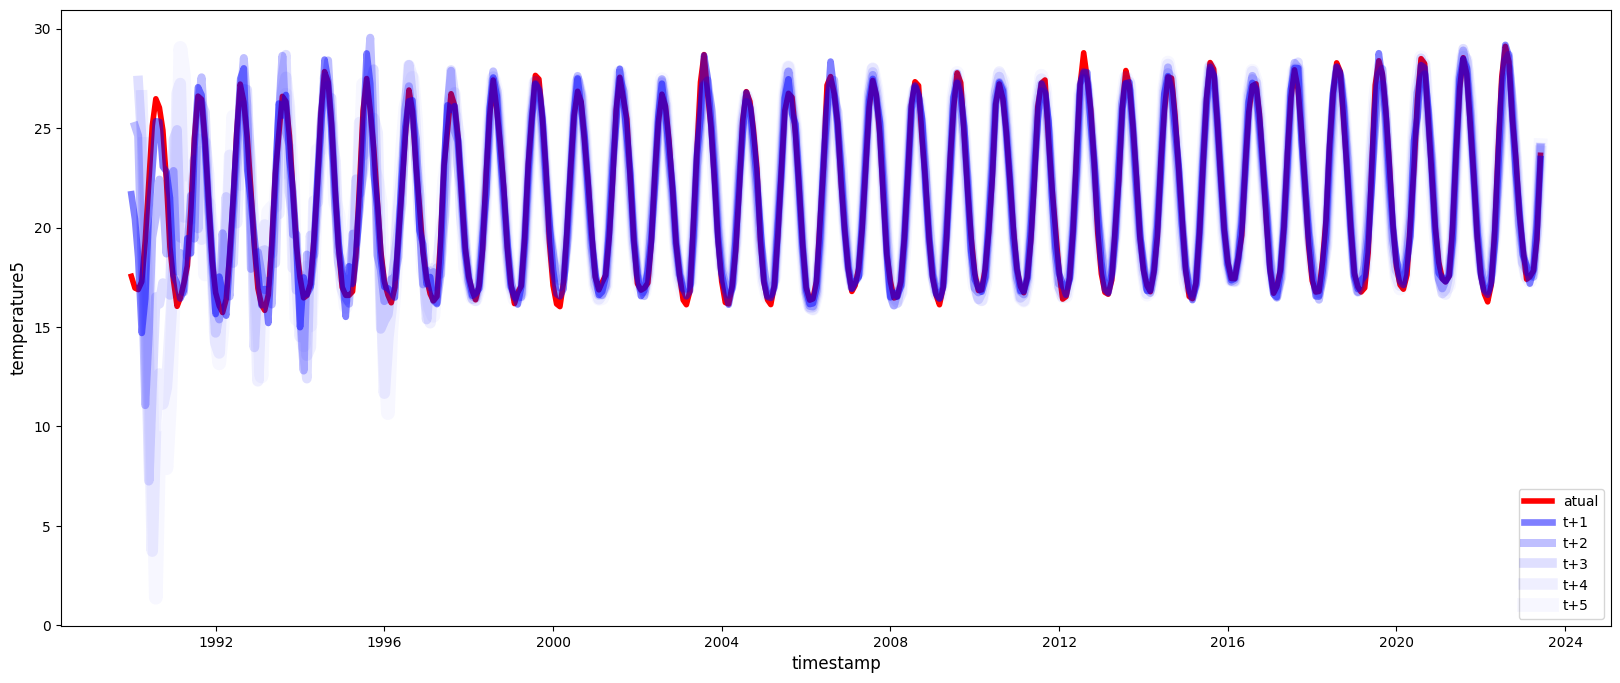

In [57]:
## Plotting multi step forecast
plot_df = eval_df[(eval_df.h=='sst+1')][['timestamp', 'atual']]
for t in range(1, HORIZONTE+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.h=='sst+'+str(t))]['prediction'].values

plot_df.head()
fig = plt.figure(figsize=(20, 8))
plt.plot(plot_df['timestamp'], plot_df['atual'], color='red', linewidth=4.0, label='atual')

for t in range(1, HORIZONTE+1):
    x = plot_df['timestamp'][(t-1):]
    y = plot_df['t+'+str(t)][0:len(x)]
    plt.plot(x, y, color='blue', linewidth=4*math.pow(1.2,t), alpha=math.pow(0.5,t), label='t+'+str(t))

plt.legend()
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('temperature'+str(t), fontsize=12)
plt.show()

### Algumas informações sobre o modelo treinado para SST

In [51]:
print(model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0308      0.130     -0.236      0.813      -0.287       0.225
ar.L2         -0.1742      0.146     -1.190      0.234      -0.461       0.113
ar.L3         -0.1924      0.120     -1.597      0.110      -0.429       0.044
ar.L4         -0.1235      0.160     -0.771      0.441      -0.438       0.191
ar.L5         -0.0673      0.139     -0.483      0.629      -0.341       0.206
ar.S.L24      -0.5283      0.159     -3.329      0.001      -0.839      -0.217
ar.S.L48      -0.0543      0.325     -0.167      0.867      -0.691       0.582
sigma2         0.1763      0.037      4.799      0.000       0.104       0.248


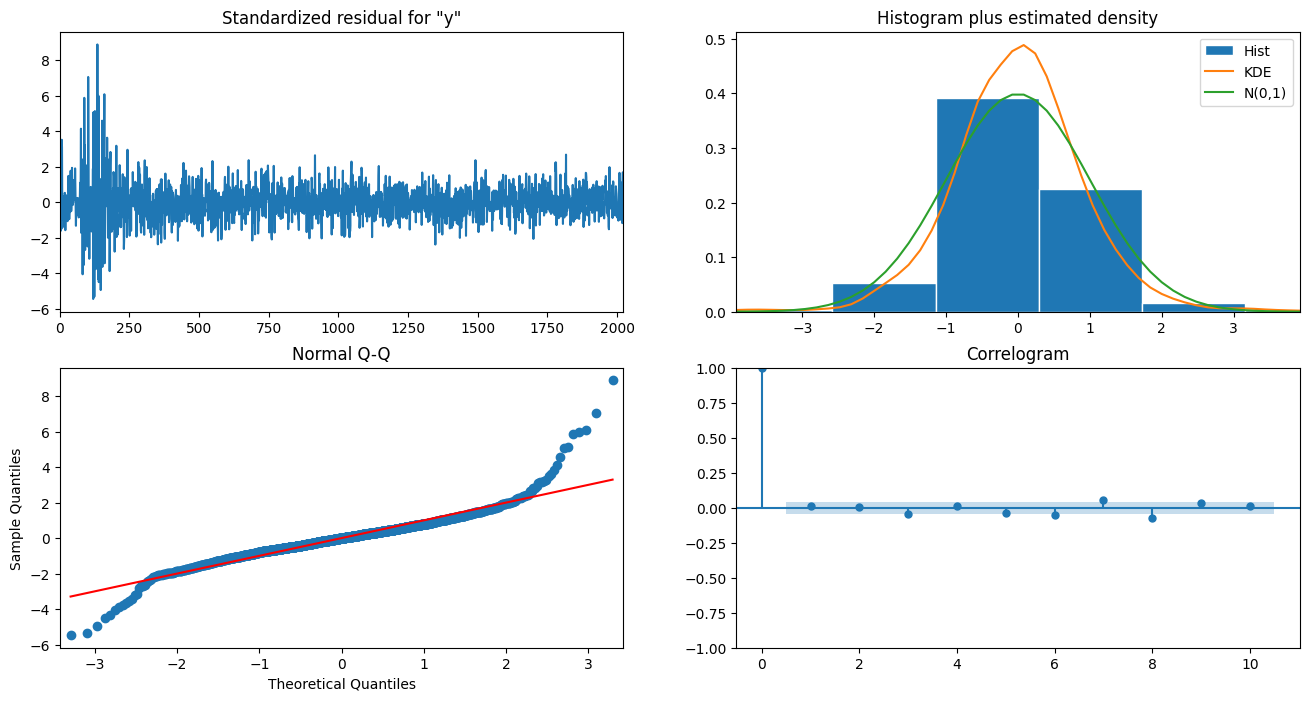

In [40]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Referências

Este projeto é uma adaptação das seguintes referências:

https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/2-ARIMA/README.md

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/

https://www.kaggle.com/code/ishanharshvardhan/time-series-analysis-and-forecasting-using-arima

